In [2]:
%load_ext autoreload
%autoreload 2

main_dir = '/Users/simon/bsose_monthly/'
salt = main_dir + 'bsose_i106_2008to2012_monthly_Salt.nc'
theta = main_dir + 'bsose_i106_2008to2012_monthly_Theta.nc'

In [2]:
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
import pyxpcm
from pyxpcm.models import pcm


def pcm_fit_and_post(time_i=42, K=4, maxvar=2):  
    # Define features to use
    # Instantiate the PCM
    
    max_depth = 2000
    z = np.arange(0., -max_depth, -10.)
    features_pcm = {'THETA': z, 'SALT': z}
    features = {'THETA': 'THETA', 'SALT': 'SALT'}
    salt_nc = xr.open_dataset(salt).isel(time=time_i)
    theta_nc = xr.open_dataset(theta).isel(time=time_i)
    big_nc = xr.merge([salt_nc, theta_nc])
    both_nc = big_nc.where(big_nc.coords['Depth'] > 
                           max_depth).drop(['iter', 'Depth', 
                                            'rA', 'drF', 'hFacC'])   
 
    attr_d = {}

    for coord in both_nc.coords:
        attr_d[coord] = both_nc.coords[coord].attrs
        
    lons_new = np.linspace(both_nc.XC.min(), both_nc.XC.max(), 60*4)
    lats_new = np.linspace(both_nc.YC.min(), both_nc.YC.max(), 60)
    # ds = both_nc # .copy(deep=True)
    ds = both_nc.interp(coords={'YC': lats_new, 'XC': lons_new})#, method='cubic')
        
    m = pcm(K=K, features=features_pcm, maxvar=maxvar, 
            timeit=True, timeit_verb=1)
    m.fit(ds, features=features, dim='Z') #, inplace=True)
    m.predict(ds, features=features, dim='Z', inplace=True)
    m.predict_proba(ds, features=features, dim='Z', inplace=True)
    m.find_i_metric(ds, inplace=True)
    
    def sanitize():
        del ds.PCM_LABELS.attrs['_pyXpcm_cleanable']
        del ds.PCM_POST.attrs['_pyXpcm_cleanable']
        del ds.PCM_RANK.attrs['_pyXpcm_cleanable']
        
    for coord in attr_d:
        ds.coords[coord].attrs = attr_d[coord]
    
    sanitize()
    return ds, m

/Users/simon/pyxpcm/pyxpcm/plot.py:45: UserWarning: pyXpcm requires seaborn installed for full plotting functionality
  warnings.warn("pyXpcm requires seaborn installed for full plotting functionality")


In [3]:
ds, m = pcm_fit_and_post(K=5)
ds

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/simon/bsose_monthly/bsose_i106_2008to2012_monthly_Salt.nc'

In [6]:
ds.THETA

<xarray.DataArray 'THETA' (Z: 52, YC: 60, XC: 240)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [16.91224107, 16.43401331, 16.42829744, ..., 16.73668129,
         16.96183119, 17.00106982],
        [17.10594605, 16.58357543,         nan, ..., 17.78552694,
         17.77893846, 17.15627046],
        [17.39700127, 17.41902259, 17.57648229, ..., 18.07164888,
         18.36557512, 17.36038017]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [16.91124901, 16.43339274, 16.42752858, ..., 16.73595127,
         16.96102677, 17.00007724],
        [17.10549598, 16.58310654,         nan, ..., 17.78463126,
         17.77757912, 17.15569575],
        [17.39632988, 17.41838157, 17.57571519, ..., 18.07098448,
         18.36467935, 17.35962105]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [16.91069974, 16.43307493, 16.42718746, ..., 16.73555945,
         16.96057151, 16.99951095],
        [17.1052305 , 16.58282718,         nan, ..., 17.78415165,
         17.77679681, 17.15536903],
        [17.39597893, 17.41795374, 17.57531644, ..., 18.07053892,
         18.36411567, 17.35921097]],

       ...,

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.        ,  0.        ,  0.29702708, ...,  0.        ,
          1.16704883,  0.        ],
        [ 0.        ,  0.        ,         nan, ...,  0.6565437 ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  1.83060692,
          0.        ,  0.        ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]])
Coordinates:
    time     datetime64[ns] 2011-08-01T15:12:00
  * Z        (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * YC       (YC) float64 -77.98 -7

In [7]:
ds.SALT

<xarray.DataArray 'SALT' (Z: 52, YC: 60, XC: 240)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [35.76241635, 35.69724222, 35.69800239, ..., 35.66702453,
         35.72830786, 35.78210389],
        [35.80910656, 35.7278929 ,         nan, ..., 35.92798663,
         35.94565591, 35.82460342],
        [35.88534927, 35.83552407, 35.89943901, ..., 35.94890202,
         36.02223367, 35.87853622]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [35.76245369, 35.69726089, 35.69800094, ..., 35.66722655,
         35.72839551, 35.78213623],
        [35.80910656, 35.72788364,         nan, ..., 35.92803851,
         35.94566214, 35.82460342],
        [35.88534164, 35.8354741 , 35.89938586, ..., 35.948915  ,
         36.02224104, 35.87853622]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [35.76246604, 35.69726589, 35.69799823, ..., 35.66740227,
         35.72845882, 35.78214477],
        [35.80910274, 35.72787431,         nan, ..., 35.92806007,
         35.9456524 , 35.82460184],
        [35.8853302 , 35.83543964, 35.89935585, ..., 35.94890432,
         36.02223341, 35.87853241]],

       ...,

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.        ,  0.        , 12.37136438, ...,  0.        ,
         24.41002681,  0.        ],
        [ 0.        ,  0.        ,         nan, ..., 13.43770223,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., 34.86512099,
          0.        ,  0.        ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]])
Coordinates:
    time     datetime64[ns] 2011-08-01T15:12:00
  * Z        (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * YC       (YC) float64 -77.98 -77

In [30]:
import gsw

def return_rho(pt_values, salt_values, lon_values, lat_values, z_values):
    
    lat_mesh, z_mesh = np.meshgrid(lat_values, z_values)
    pressure_mesh = gsw.p_from_z(z_mesh, lat_mesh)
    pressure_values = np.zeros(np.shape(pt_values))
    lat_grid = np.zeros(np.shape(pt_values))
    lon_grid = np.zeros(np.shape(pt_values))

    for i in range(np.shape(pt_values)[2]):
        pressure_values[:, :, i] = pressure_mesh[:, :]
        lat_grid[:, :, i] = lat_mesh[:, :]
    
    for i in range(np.shape(pt_values)[0]):
        for j in range(np.shape(pt_values)[1]):
            lon_grid[i, j, :] = lon_values[:]
            
    sa_values = gsw.SA_from_SP(salt_values, pressure_values, lon_grid, lat_grid)
    ct_values = gsw.conversions.CT_from_pt(sa_values, pt_values)
    rho_values = gsw.density.rho(sa_values, ct_values, pressure_values)
    print(np.shape(rho_values))
    return rho_values, ct_values, pressure_values
    
rho_values, ct_values, pressure_values = return_rho(ds.where(ds.THETA!=0.0).THETA.values, 
                                                    ds.where(ds.SALT!=0.0).SALT.values, 
                                                    ds.XC.values, ds.YC.values, ds.Z.values)

def rho_values_dataset(dataset, rho_values, propagate=True):
    if propagate:
        attr_d = {}
        for coord in dataset.coords:
            attr_d[coord] = dataset.coords[coord].attrs
    
    da = xr.DataArray(rho_values, dims=["Z", "YC", "XC"], 
                      coords=[ds.Z.values, ds.YC.values, ds.XC.values]).rename('rho')
    
    da.attrs['long_name'] = 'Density'
    da.attrs['units'] = 'kg m^{-3}'
    da.attrs['valid_min'] = 1000 
    da.attrs['valid_max'] = 1100
    
    if propagate:
        for coord in attr_d:
            if coord != 'time':
                da.coords[coord].attrs = attr_d[coord]
    dataset[da.name] = da
    
    if propagate:
        for coord in attr_d:
            dataset.coords[coord].attrs = attr_d[coord]

    return dataset, da


def ct_values_dataset(dataset, ct_values, propagate=True):
    if propagate:
        attr_d = {}
        for coord in dataset.coords:
            attr_d[coord] = dataset.coords[coord].attrs
    
    da = xr.DataArray(ct_values, dims=["Z", "YC", "XC"], 
                      coords=[ds.Z.values, ds.YC.values, ds.XC.values]).rename('ct')
    
    da.attrs['long_name'] = 'Conservative Temperature'
    da.attrs['units'] = 'degC'
    
    if propagate:
        for coord in attr_d:
            if coord != 'time':
                da.coords[coord].attrs = attr_d[coord]
    dataset[da.name] = da
    
    if propagate:
        for coord in attr_d:
            dataset.coords[coord].attrs = attr_d[coord]

    return dataset, da


def pressure_values_dataset(dataset, pressure_values, propagate=True):
    if propagate:
        attr_d = {}
        for coord in dataset.coords:
            attr_d[coord] = dataset.coords[coord].attrs
    
    da = xr.DataArray(pressure_values, dims=["Z", "YC", "XC"], 
                      coords=[ds.Z.values, ds.YC.values, 
                              ds.XC.values]).rename('Pressure')
    
    da.attrs['long_name'] = 'Pressure'
    da.attrs['units'] = 'Pa'
    
    if propagate:
        for coord in attr_d:
            if coord != 'time':
                da.coords[coord].attrs = attr_d[coord]
    dataset[da.name] = da
    
    if propagate:
        for coord in attr_d:
            dataset.coords[coord].attrs = attr_d[coord]

    return dataset, da


ds, da = rho_values_dataset(ds, rho_values)
ds, da = ct_values_dataset(ds, ct_values)
ds, da = pressure_values_dataset(ds, pressure_values)


(52, 60, 240)


In [31]:
np.shape(ds.YC.values)

(60,)

In [32]:
ds.to_netcdf('density_2.nc', engine='netcdf4')

In [16]:
ds.SALT

<xarray.DataArray 'SALT' (Z: 52, YC: 60, XC: 240)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [35.76241635, 35.69724222, 35.69800239, ..., 35.66702453,
         35.72830786, 35.78210389],
        [35.80910656, 35.7278929 ,         nan, ..., 35.92798663,
         35.94565591, 35.82460342],
        [35.88534927, 35.83552407, 35.89943901, ..., 35.94890202,
         36.02223367, 35.87853622]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [35.76245369, 35.69726089, 35.69800094, ..., 35.66722655,
         35.72839551, 35.78213623],
        [35.80910656, 35.72788364,         nan, ..., 35.92803851,
         35.94566214, 35.82460342],
        [35.88534164, 35.8354741 , 35.89938586, ..., 35.948915  ,
         36.02224104, 35.87853622]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [35.76246604, 35.69726589, 35.69799823, ..., 35.66740227,
         35.72845882, 35.78214477],
        [35.80910274, 35.72787431,         nan, ..., 35.92806007,
         35.9456524 , 35.82460184],
        [35.8853302 , 35.83543964, 35.89935585, ..., 35.94890432,
         36.02223341, 35.87853241]],

       ...,

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.        ,  0.        , 12.37136438, ...,  0.        ,
         24.41002681,  0.        ],
        [ 0.        ,  0.        ,         nan, ..., 13.43770223,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., 34.86512099,
          0.        ,  0.        ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]])
Coordinates:
    time     datetime64[ns] 2011-08-01T15:12:00
  * Z        (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * YC       (YC) float64 -77.98 -77

In [77]:
ds.ct


<xarray.DataArray 'ct' (Z: 52, YC: 60, XC: 240)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [3.67011177e+01, 3.66580791e+01, 3.66591429e+01, ...,
         3.66120537e+01, 3.66636873e+01, 3.67168744e+01],
        [3.67393238e+01, 3.66820770e+01,            nan, ...,
         3.68271828e+01, 3.68456057e+01, 3.67526962e+01],
        [3.68029253e+01, 3.67507821e+01, 3.68083936e+01, ...,
         3.68342879e+01, 3.68946241e+01, 3.67977740e+01]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [3.67012054e+01, 3.66581291e+01, 3.66591796e+01, ...,
         3.66122971e+01, 3.66638171e+01, 3.67169570e+01],
        [3.67393462e+01, 3.66820909e+01,            nan, ...,
         3.68272807e+01, 3.68456801e+01, 3.67527249e+01],
        [3.68029510e+01, 3.67507628e+01, 3.68083774e+01, ...,
         3.68343345e+01, 3.68946766e+01, 3.67978119e+01]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [3.67012454e+01, 3.66581500e+01, 3.66591938e+01, ...,
         3.66124967e+01, 3.66639046e+01, 3.67169939e+01],
        [3.67393556e+01, 3.66820952e+01,            nan, ...,
         3.68273267e+01, 3.68457092e+01, 3.67527396e+01],
        [3.68029568e+01, 3.67507489e+01, 3.68083666e+01, ...,
         3.68343458e+01, 3.68946970e+01, 3.67978285e+01]],

       ...,

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [1.52844796e-02, 1.52844796e-02, 1.30365579e+01, ...,
         1.52844796e-02, 2.56227143e+01, 1.52844796e-02],
        [1.52844796e-02, 1.52844796e-02,            nan, ...,
         1.41482578e+01, 1.52844796e-02, 1.52844796e-02],
        [1.52844796e-02, 1.52844796e-02, 1.52844796e-02, ...,
         3.65202188e+01, 1.52844796e-02, 1.52844796e-02]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [1.52844796e-02, 1.52844796e-02, 1.52844796e-02, ...,
         1.52844796e-02, 1.52844796e-02, 1.52844796e-02],
        [1.52844796e-02, 1.52844796e-02,            nan, ...,
         1.52844796e-02, 1.52844796e-02, 1.52844796e-02],
        [1.52844796e-02, 1.52844796e-02, 1.52844796e-02, ...,
         1.52844796e-02, 1.52844796e-02, 1.52844796e-02]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan

In [78]:
ds.pressure

<xarray.DataArray 'pressure' (Z: 52, YC: 60, XC: 240)>
array([[[2.12231676e+00, 2.12231676e+00, 2.12231676e+00, ...,
         2.12231676e+00, 2.12231676e+00, 2.12231676e+00],
        [2.12224931e+00, 2.12224931e+00, 2.12224931e+00, ...,
         2.12224931e+00, 2.12224931e+00, 2.12224931e+00],
        [2.12217773e+00, 2.12217773e+00, 2.12217773e+00, ...,
         2.12217773e+00, 2.12217773e+00, 2.12217773e+00],
        ...,
        [2.11462878e+00, 2.11462878e+00, 2.11462878e+00, ...,
         2.11462878e+00, 2.11462878e+00, 2.11462878e+00],
        [2.11448807e+00, 2.11448807e+00, 2.11448807e+00, ...,
         2.11448807e+00, 2.11448807e+00, 2.11448807e+00],
        [2.11434958e+00, 2.11434958e+00, 2.11434958e+00, ...,
         2.11434958e+00, 2.11434958e+00, 2.11434958e+00]],

       [[6.77127765e+00, 6.77127765e+00, 6.77127765e+00, ...,
         6.77127765e+00, 6.77127765e+00, 6.77127765e+00],
        [6.77106243e+00, 6.77106243e+00, 6.77106243e+00, ...,
         6.77106243e+00, 6.77106243e+00, 6.77106243e+00],
        [6.77083404e+00, 6.77083404e+00, 6.77083404e+00, ...,
         6.77083404e+00, 6.77083404e+00, 6.77083404e+00],
        ...,
        [6.74674876e+00, 6.74674876e+00, 6.74674876e+00, ...,
         6.74674876e+00, 6.74674876e+00, 6.74674876e+00],
        [6.74629982e+00, 6.74629982e+00, 6.74629982e+00, ...,
         6.74629982e+00, 6.74629982e+00, 6.74629982e+00],
        [6.74585796e+00, 6.74585796e+00, 6.74585796e+00, ...,
         6.74585796e+00, 6.74585796e+00, 6.74585796e+00]],

       [[1.22794214e+01, 1.22794214e+01, 1.22794214e+01, ...,
         1.22794214e+01, 1.22794214e+01, 1.22794214e+01],
        [1.22790311e+01, 1.22790311e+01, 1.22790311e+01, ...,
         1.22790311e+01, 1.22790311e+01, 1.22790311e+01],
        [1.22786169e+01, 1.22786169e+01, 1.22786169e+01, ...,
         1.22786169e+01, 1.22786169e+01, 1.22786169e+01],
        ...,
        [1.22349387e+01, 1.22349387e+01, 1.22349387e+01, ...,
         1.22349387e+01, 1.22349387e+01, 1.22349387e+01],
        [1.22341246e+01, 1.22341246e+01, 1.22341246e+01, ...,
         1.22341246e+01, 1.22341246e+01, 1.22341246e+01],
        [1.22333233e+01, 1.22333233e+01, 1.22333233e+01, ...,
         1.22333233e+01, 1.22333233e+01, 1.22333233e+01]],

       ...,

       [[5.11337962e+03, 5.11337962e+03, 5.11337962e+03, ...,
         5.11337962e+03, 5.11337962e+03, 5.11337962e+03],
        [5.11321533e+03, 5.11321533e+03, 5.11321533e+03, ...,
         5.11321533e+03, 5.11321533e+03, 5.11321533e+03],
        [5.11304099e+03, 5.11304099e+03, 5.11304099e+03, ...,
         5.11304099e+03, 5.11304099e+03, 5.11304099e+03],
        ...,
        [5.09465603e+03, 5.09465603e+03, 5.09465603e+03, ...,
         5.09465603e+03, 5.09465603e+03, 5.09465603e+03],
        [5.09431335e+03, 5.09431335e+03, 5.09431335e+03, ...,
         5.09431335e+03, 5.09431335e+03, 5.09431335e+03],
        [5.09397608e+03, 5.09397608e+03, 5.09397608e+03, ...,
         5.09397608e+03, 5.09397608e+03, 5.09397608e+03]],

       [[5.52749440e+03, 5.52749440e+03, 5.52749440e+03, ...,
         5.52749440e+03, 5.52749440e+03, 5.52749440e+03],
        [5.52731667e+03, 5.52731667e+03, 5.52731667e+03, ...,
         5.52731667e+03, 5.52731667e+03, 5.52731667e+03],
        [5.52712806e+03, 5.52712806e+03, 5.52712806e+03, ...,
         5.52712806e+03, 5.52712806e+03, 5.52712806e+03],
        ...,
        [5.50723850e+03, 5.50723850e+03, 5.50723850e+03, ...,
         5.50723850e+03, 5.50723850e+03, 5.50723850e+03],
        [5.50686778e+03, 5.50686778e+03, 5.50686778e+03, ...,
         5.50686778e+03, 5.50686778e+03, 5.50686778e+03],
        [5.50650291e+03, 5.50650291e+03, 5.50650291e+03, ...,
         5.50650291e+03, 5.50650291e+03, 5.50650291e+03]],

       [[5.94233050e+03, 5.94233050e+03, 5.94233050e+03, ...,
         5.94233050e+03, 5.94233050e+03, 5.94233050e+03],
        [5.94213928e+03, 5.94213928e+03, 5.94213928e+03, ...,
         5.94213928e+03, 5.94213928e+03, 5.94213928e+03],
        [5.941936

In [60]:
da

<xarray.DataArray 'rho' (Z: 52, YC: 60, XC: 240)>
array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [1019.73074144, 1019.70048581, 1019.7006219 , ...,
         1019.69651067, 1019.72066766, 1019.73881143],
        [1019.74955093, 1019.71326518,           nan, ...,
         1019.80102743, 1019.80659163, 1019.75552326],
        [1019.77976419, 1019.76411775, 1019.78777838, ...,
         1019.81331308, 1019.84263723, 1019.77685987]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [1019.74980189, 1019.71955097, 1019.71967764, ...,
         1019.71563587, 1019.73975051, 1019.75786905],
        [1019.76860561, 1019.73232111,           nan, ...,
         1019.82008329, 1019.82562253, 1019.77457456],
        [1019.79880615, 1019.78315016, 1019.8068032 , ...,
         1019.83235876, 1019.86167209, 1019.79590299]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [1019.77238414, 1019.74213953, 1019.74226318, ...,
         1019.73828152, 1019.762354  , 1019.78044832],
        [1019.79118322, 1019.75490211,           nan, ...,
         1019.84265677, 1019.84817858, 1019.79715054],
        [1019.82137258, 1019.80571186, 1019.82936201, ...,
         1019.85492002, 1019.8842267 , 1019.81847121]],

       ...,

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [1024.28566226, 1024.28566226, 1031.16845032, ...,
         1024.28566226, 1035.97888059, 1024.28566226],
        [1024.28411455, 1024.28411455,           nan, ...,
         1031.65957464, 1024.28411455, 1024.28411455],
        [1024.28259124, 1024.28259124, 1024.28259124, ...,
         1039.04208212, 1024.28259124, 1024.28259124]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [1026.13995448, 1026.13995448, 1026.13995448, ...,
         1026.13995448, 1026.13995448, 1026.13995448],
        [1026.13829651, 1026.13829651,           nan, ...,
         1026.13829651, 1026.13829651, 1026.13829651],
        [1026.13666468, 1026.13666468, 1026.13666468, ...,
         1026.13666468, 1026.13666468, 1026.13666468]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [1027.97923148, 1027.97923148, 1027.97923148, ...,
         1027.97923148, 1027

In [12]:
def density_pcm_fit_and_post(ds, K=5, maxvar=2):  
    # Define features to use
    # Instantiate the PCM
    
    max_depth = 2000
    z = np.arange(0., -max_depth, -10.)
    features_pcm = {'rho': z}
    features = {'rho':'rho'}
    ds = ds.drop(['PCM_LABELS', 'PCM_POST', 'PCM_RANK'])   
 
    attr_d = {}

    for coord in ds.coords:
        attr_d[coord] = ds.coords[coord].attrs
            
    m = pcm(K=K, features=features_pcm, maxvar=maxvar, 
            timeit=True, timeit_verb=1)
    m.fit(ds, features=features, dim='Z') #, inplace=True)
    m.predict(ds, features=features, dim='Z', inplace=True)
    m.predict_proba(ds, features=features, dim='Z', inplace=True)
    m.find_i_metric(ds, inplace=True)
    
    def sanitize():
        del ds.PCM_LABELS.attrs['_pyXpcm_cleanable']
        del ds.PCM_POST.attrs['_pyXpcm_cleanable']
        del ds.PCM_RANK.attrs['_pyXpcm_cleanable']
        
    for coord in attr_d:
        ds.coords[coord].attrs = attr_d[coord]
    
    sanitize()
    return ds, m

In [13]:
ds1, m1 = density_pcm_fit_and_post(ds, K=5, maxvar=2)

  fit.1-preprocess.1-mask: 17 ms
  fit.1-preprocess.2-feature_rho.1-ravel: 21 ms
  fit.1-preprocess.2-feature_rho.2-interp: 26 ms
  fit.1-preprocess.2-feature_rho.3-scale_fit: 75 ms
  fit.1-preprocess.2-feature_rho.4-scale_transform: 29 ms
  fit.1-preprocess.2-feature_rho.5-reduce_fit: 53 ms
  fit.1-preprocess.2-feature_rho.6-reduce_transform: 8 ms
  fit.1-preprocess.2-feature_rho.total: 215 ms
  fit.1-preprocess: 215 ms
  fit.1-preprocess.3-homogeniser: 0 ms
  fit.1-preprocess.4-xarray: 1 ms
  fit.1-preprocess: 235 ms
  fit.fit: 1751 ms
  fit.score: 2 ms
  fit: 1989 ms
  predict.1-preprocess.1-mask: 6 ms
  predict.1-preprocess.2-feature_rho.1-ravel: 13 ms
  predict.1-preprocess.2-feature_rho.2-interp: 16 ms
  predict.1-preprocess.2-feature_rho.3-scale_fit: 0 ms
  predict.1-preprocess.2-feature_rho.4-scale_transform: 51 ms
  predict.1-preprocess.2-feature_rho.5-reduce_fit: 0 ms
  predict.1-preprocess.2-feature_rho.6-reduce_transform: 6 ms
  predict.1-preprocess.2-feature_rho.total: 88 

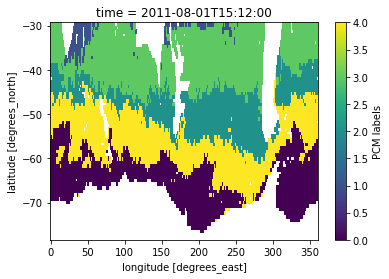

In [14]:
ds1.PCM_LABELS.plot()

In [38]:
import pyxpcm.transformations as tran

density_da, ct_da, pressure_da, theta_da = tran.test_density_da()
density_da = density_da.expand_dims(dim='time', axis=None)
density_da = density_da.assign_coords({"time":
        ("time", [ds.coords['time'].values])})
density_da.coords['time'].attrs = ds.coords['time'].attrs

()
()
()
()


In [39]:
density_da


<xarray.DataArray 'Density' (time: 1, Z: 52, YC: 588, XC: 2160)>
array([[[[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         ...,
         [1026.13957224, 1026.14957019, 1026.15232248, ...,
          1026.10499898, 1026.11900131, 1026.13075893],
         [1026.12953516, 1026.13914495, 1026.14442756, ...,
          1026.10321502, 1026.11792812, 1026.12490458],
         [1026.11113348, 1026.11656161, 1026.12366577, ...,
          1026.09982183, 1026.11415567, 1026.11479455]],

        [[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         ...,
         [1026.15984323, 1026.16982416, 1026.17256755, ...,
          1026.12525955, 1026.13929951, 1026.15104004],
         [1026.14983329, 1026.15942558, 1026.16469056, ...,
          1026.12349381, 1026.13825059, 1026.14521868],
         [1026.1314679 , 1026.13686954, 1026.1439543 , ...,
          1026.12014585, 1026.13453692, 1026.135159  ]],

        [[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         ...,
         [1026.18379096, 1026.19376692, 1026.19650788, ...,
          1026.14919   , 1026.16326283, 1026.17499602],
         [1026.17378896, 1026.18337368, 1026.18863039, ...,
          1026.14743475, 1026.16222521, 1026.16918628],
         [1026.15544455, 1026.16082927, 1026.16790543, ...,
          1026.14410169, 1026.15854608, 1026.15915953]],

        ...,

        [[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         ...,
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
          1050.53345403,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan]],

        [[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         ...,
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan]],

        [[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         ...,

In [35]:

#density_da = density_da.assign_coords({"time":
#        ("time", [ds.coords['time'].values])})
density_da

ValueError: Dimension time already exists.

In [63]:
theta_da

<xarray.DataArray 'THETA' (Z: 52, YC: 588, XC: 2160)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [17.272978 , 17.281185 , 17.275349 , ..., 17.566721 ,
         17.314592 , 17.283361 ],
        [17.320377 , 17.334515 , 17.348282 , ..., 17.572117 ,
         17.326769 , 17.31259  ],
        [17.397001 , 17.422977 , 17.43458  , ..., 17.618649 ,
         17.357294 , 17.36038  ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [17.272608 , 17.280869 , 17.27507  , ..., 17.566334 ,
         17.314123 , 17.282948 ],
        [17.31988  , 17.33407  , 17.347904 , ..., 17.571665 ,
         17.326195 , 17.312054 ],
        [17.39633  , 17.422369 , 17.434046 , ..., 17.618008 ,
         17.356491 , 17.359621 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [17.272436 , 17.280724 , 17.274937 , ..., 17.56613  ,
         17.313887 , 17.28274  ],
        [17.319656 , 17.33387  , 17.34773  , ..., 17.571451 ,
         17.325918 , 17.311798 ],
        [17.395979 , 17.422075 , 17.43378  , ..., 17.617714 ,
         17.356071 , 17.359211 ]],

       ...,

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  1.8385302,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2011-08-01T15:12:00
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.98265 -77.9479 -77.91305 ... -29.870987 -29.715317
  * Z        (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
Attributes:
    units:          degC
    long_name:      Potential Temperature
 

In [69]:
list = [0, 1, 2]
print(list.reverse())

None


In [73]:
ds.THETA

<xarray.DataArray 'THETA' (Z: 52, YC: 60, XC: 240)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [16.91224107, 16.43401331, 16.42829744, ..., 16.73668129,
         16.96183119, 17.00106982],
        [17.10594605, 16.58357543,         nan, ..., 17.78552694,
         17.77893846, 17.15627046],
        [17.39700127, 17.41902259, 17.57648229, ..., 18.07164888,
         18.36557512, 17.36038017]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [16.91124901, 16.43339274, 16.42752858, ..., 16.73595127,
         16.96102677, 17.00007724],
        [17.10549598, 16.58310654,         nan, ..., 17.78463126,
         17.77757912, 17.15569575],
        [17.39632988, 17.41838157, 17.57571519, ..., 18.07098448,
         18.36467935, 17.35962105]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [16.91069974, 16.43307493, 16.42718746, ..., 16.73555945,
         16.96057151, 16.99951095],
        [17.1052305 , 16.58282718,         nan, ..., 17.78415165,
         17.77679681, 17.15536903],
        [17.39597893, 17.41795374, 17.57531644, ..., 18.07053892,
         18.36411567, 17.35921097]],

       ...,

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.        ,  0.        ,  0.29702708, ...,  0.        ,
          1.16704883,  0.        ],
        [ 0.        ,  0.        ,         nan, ...,  0.6565437 ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  1.83060692,
          0.        ,  0.        ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]])
Coordinates:
    time     datetime64[ns] 2011-08-01T15:12:00
  * Z        (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * YC       (YC) float64 -77.98 -7

In [79]:
salt_nc = xr.open_dataset(salt)

In [81]:
salt_nc.dims['time']

60

In [ ]:
import pyxpcm.transformations as tran
# tran.create_whole_density_netcdf()

tran.y_grad()

/Users/simon/pyxpcm/pyxpcm/plot.py:45: UserWarning: pyXpcm requires seaborn installed for full plotting functionality
  warnings.warn("pyXpcm requires seaborn installed for full plotting functionality")
/Users/simon/pyxpcm/pyxpcm/transformations.py:202: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  density_da = xr.open_mfdataset('nc/density.nc')
/Users/simon/anaconda3/envs/fronts/lib/python3.8/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future,

In [1]:
#import pyxpcm.transformations as tran
import xarray as xr
#density_da = tran.merge_whole_density_netcdf()
#density_da = tran.reload_density_netcdf()
density_da = xr.open_mfdataset('nc/density.nc')

<ipython-input-1-f2294aecedb1>:5: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  density_da = xr.open_mfdataset('nc/density.nc')
/Users/simon/anaconda3/envs/fronts/lib/python3.8/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(


In [2]:
density_da

<xarray.Dataset>
Dimensions:  (XC: 2160, YC: 588, Z: 52, time: 60)
Coordinates:
  * Z        (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.98265 -77.9479 -77.91305 ... -29.870987 -29.715317
  * time     (time) datetime64[ns] 2008-01-31T10:24:00 ... 2012-12-31
Data variables:
    Density  (time, Z, YC, XC) float64 dask.array<chunksize=(60, 52, 588, 2160), meta=np.ndarray>

In [21]:
grad_da = density_da.Density.differentiate("YC")
density_da['y_grad'] = grad_da
grad_ds = density_da.drop('Density')
xr.save_mfdataset([grad_ds], ['nc/density_grad_y.nc'], format='NETCDF4')

In [ ]:
grad_da = density_da.Density.differentiate("XC")
density_da['x_grad'] = grad_da
grad_ds = density_da.drop('Density')
xr.save_mfdataset([grad_ds], ['nc/density_grad_x.nc'], format='NETCDF4')

In [17]:
density_da.Density.differentiate("YC")

,Array,Chunk
Bytes,31.70 GB,528.35 MB
Shape,"(60, 52, 588, 2160)","(1, 52, 588, 2160)"
Count,540 Tasks,60 Chunks
Type,float64,numpy.ndarray


In [44]:
import xarray as xr
xr.set_options(keep_attrs=True)
da0 = xr.open_dataset('nc/rho/density_' + str(0) + '.nc')

In [31]:
#da0 = da0.expand_dims(dim='time', axis=None)
da0 = da0.assign_coords({"time": ("time", [ds.coords['time'].values])})
da0

<xarray.Dataset>
Dimensions:  (XC: 2160, YC: 588, Z: 52, time: 1)
Coordinates:
  * Z        (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * YC       (YC) float32 -77.98265 -77.9479 -77.91305 ... -29.870987 -29.715317
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * time     (time) datetime64[ns] 2011-08-01T15:12:00
Data variables:
    Density  (Z, YC, XC) float64 ...

In [21]:
ds.THETA

<xarray.DataArray 'THETA' (Z: 52, YC: 60, XC: 240)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [16.91224107, 16.43401331, 16.42829744, ..., 16.73668129,
         16.96183119, 17.00106982],
        [17.10594605, 16.58357543,         nan, ..., 17.78552694,
         17.77893846, 17.15627046],
        [17.39700127, 17.41902259, 17.57648229, ..., 18.07164888,
         18.36557512, 17.36038017]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [16.91124901, 16.43339274, 16.42752858, ..., 16.73595127,
         16.96102677, 17.00007724],
        [17.10549598, 16.58310654,         nan, ..., 17.78463126,
         17.77757912, 17.15569575],
        [17.39632988, 17.41838157, 17.57571519, ..., 18.07098448,
         18.36467935, 17.35962105]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [16.91069974, 16.43307493, 16.42718746, ..., 16.73555945,
         16.96057151, 16.99951095],
        [17.1052305 , 16.58282718,         nan, ..., 17.78415165,
         17.77679681, 17.15536903],
        [17.39597893, 17.41795374, 17.57531644, ..., 18.07053892,
         18.36411567, 17.35921097]],

       ...,

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.        ,  0.        ,  0.29702708, ...,  0.        ,
          1.16704883,  0.        ],
        [ 0.        ,  0.        ,         nan, ...,  0.6565437 ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  1.83060692,
          0.        ,  0.        ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,         nan, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]])
Coordinates:
    time     datetime64[ns] 2011-08-01T15:12:00
  * Z        (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * YC       (YC) float64 -77.98 -7

In [13]:
import xarray as xr

rho_da = xr.open_mfdataset('nc/rho/*.nc', concat_dim="time",
                           combine='by_coords',
                           data_vars='minimal', 
                           coords='minimal', compat='override')


In [13]:
rho_da

,Array,Chunk
Bytes,31.70 GB,528.35 MB
Shape,"(60, 52, 588, 2160)","(1, 52, 588, 2160)"
Count,180 Tasks,60 Chunks
Type,float64,numpy.ndarray


In [14]:
for time_i in range(len(rho_da.coords['time'].values)):
    print(rho_da.coords['time'].values[time_i])

2008-01-31T10:24:00.000000000
2008-03-01T20:48:00.000000000
2008-04-01T07:12:00.000000000
2008-05-01T17:36:00.000000000
2008-06-01T04:00:00.000000000
2008-07-01T14:24:00.000000000
2008-08-01T00:48:00.000000000
2008-08-31T11:12:00.000000000
2008-09-30T21:36:00.000000000
2008-10-31T08:00:00.000000000
2008-11-30T18:24:00.000000000
2008-12-31T04:48:00.000000000
2009-01-30T15:12:00.000000000
2009-03-02T01:36:00.000000000
2009-04-01T12:00:00.000000000
2009-05-01T22:24:00.000000000
2009-06-01T08:48:00.000000000
2009-07-01T19:12:00.000000000
2009-08-01T05:36:00.000000000
2009-08-31T16:00:00.000000000
2009-10-01T02:24:00.000000000
2009-10-31T12:48:00.000000000
2009-11-30T23:12:00.000000000
2009-12-31T09:36:00.000000000
2010-01-30T20:00:00.000000000
2010-03-02T06:24:00.000000000
2010-04-01T16:48:00.000000000
2010-05-02T03:12:00.000000000
2010-06-01T13:36:00.000000000
2010-07-02T00:00:00.000000000
2010-08-01T10:24:00.000000000
2010-08-31T20:48:00.000000000
2010-10-01T07:12:00.000000000
2010-10-31

In [15]:
xr.save_mfdataset([rho_da], ['nc/Density.nc'], format='NETCDF4')
# breaks

In [14]:
rho_da

,Array,Chunk
Bytes,31.70 GB,528.35 MB
Shape,"(60, 52, 588, 2160)","(1, 52, 588, 2160)"
Count,180 Tasks,60 Chunks
Type,float64,numpy.ndarray


In [15]:
rho_da.Density

,Array,Chunk
Bytes,31.70 GB,528.35 MB
Shape,"(60, 52, 588, 2160)","(1, 52, 588, 2160)"
Count,180 Tasks,60 Chunks
Type,float64,numpy.ndarray


In [4]:
import xarray as xr
density_da = xr.open_mfdataset('nc/density.nc', decode_cf=False).astype('float32')

<ipython-input-4-f3d07353f7b1>:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  density_da = xr.open_mfdataset('nc/density.nc', decode_cf=False).astype('float32')
/Users/simon/anaconda3/envs/fronts/lib/python3.8/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(


In [5]:
density_da

<xarray.Dataset>
Dimensions:  (XC: 2160, YC: 588, Z: 52, time: 60)
Coordinates:
  * Z        (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.98265 -77.9479 -77.91305 ... -29.870987 -29.715317
  * time     (time) int64 0 43824 87648 131472 ... 2497968 2541792 2585616
Data variables:
    Density  (time, Z, YC, XC) float32 dask.array<chunksize=(60, 52, 588, 2160), meta=np.ndarray>

In [6]:
rho = density_da.Density

In [7]:
rho.to_dataset()

<xarray.Dataset>
Dimensions:  (XC: 2160, YC: 588, Z: 52, time: 60)
Coordinates:
  * Z        (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.98265 -77.9479 -77.91305 ... -29.870987 -29.715317
  * time     (time) int64 0 43824 87648 131472 ... 2497968 2541792 2585616
Data variables:
    Density  (time, Z, YC, XC) float32 dask.array<chunksize=(60, 52, 588, 2160), meta=np.ndarray>

In [2]:
import xarray as xr
xr.set_options(keep_attrs=True)


def take_derivative_density(dimension="YC", typ='float32', engine='netcdf4'):
    density_da = xr.open_mfdataset('nc/density.nc',
                                   #engine=engine,
                                   #decode_cf=False,
                                   combine='by_coords',
                                   data_vars='minimal',
                                   coords='minimal', 
                                   compat='override',
                                   #parallel=True
                                   ).astype(typ)
    grad_da = density_da.Density.astype(typ).differentiate(dimension).astype(typ)
    #del density_da
    #grad_da.isel(time=slice(0,10)).to_netcdf('nc/density_grad_' + dimension + '_da.nc', 
    #                  engine=engine, encoding={'Density': {'dtype': typ}})
    
    grad_ds = grad_da.to_dataset().astype('float32')
    xr.save_mfdataset([grad_ds],
                      ['nc/density_grad_' + dimension + '.nc'],
                      format=engine)

In [ ]:
take_derivative_density()

In [ ]:
take_derivative_density(dimension='XC')

<ipython-input-1-ec09a5957b4f>:6: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  density_da = xr.open_mfdataset('nc/density.nc',
/Users/simon/anaconda3/envs/fronts/lib/python3.8/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(


In [1]:
import xarray as xr
xr.set_options(keep_attrs=True)

density_da = xr.open_mfdataset('nc/density.nc',
                                #engine=engine,
                                #decode_cf=False,
                                combine='by_coords',
                                data_vars='minimal',
                                coords='minimal', 
                                compat='override',
                                #parallel=True
                                ).isel(time=slice(0,60)).astype('float32')

density_da.chunk(chunks={'time': 1, 'Z': 1, 'YC': 588, 'XC': 2160})


,Array,Chunk
Bytes,15.85 GB,5.08 MB
Shape,"(60, 52, 588, 2160)","(1, 1, 588, 2160)"
Count,6243 Tasks,3120 Chunks
Type,float32,numpy.ndarray


In [2]:
grad_da = density_da.Density.astype('float32').differentiate("YC").astype('float32').chunk(chunks={'time': 1, 'Z': 1, 'YC': 588, 'XC': 2160})
grad_ds = grad_da.to_dataset().astype('float32').chunk(chunks={'time': 1, 'Z': 1, 'YC': 588, 'XC': 2160})


In [3]:
grad_ds

,Array,Chunk
Bytes,15.85 GB,5.08 MB
Shape,"(60, 52, 588, 2160)","(1, 1, 588, 2160)"
Count,6249 Tasks,3120 Chunks
Type,float32,numpy.ndarray


In [ ]:
xr.save_mfdataset([grad_ds],
                  ['nc/density_grad_YC.nc'],
                  format='NETCDF4')

In [ ]:
import pyxpcm.transformations as tran
tran.take_derivative_density()



In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
tran.take_derivative_density(dimension='XC')
